# Ridge Regression with Heiken Ashi & Trend Features
This notebook trains a Ridge Regression model to predict next-day returns using:
- **Heiken Ashi**: ha_open, ha_high, ha_low, ha_close (ratios or raw values)
- **Market Structure**: bos, choch, mss
- **SMA**: sma_20, sma_50 ratios
- **Indicators**: rsi_14, macd histogram

We also explore custom regularization where Heiken Ashi features are penalized less.


## 0) Setup


In [6]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- Setup correct working directory (ROOT) ---
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

ROOT = os.getcwd()
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from src.backtester.data import align_close_prices
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.models import EqualWeightAllocator

FEATURES_PARQUET_PATH = 'dataset/features/all_features.parquet'
TARGET_COL = 'ret_1d'
TARGET_FWD_COL = 'y_ret_1d_fwd'


## 1) Data Loading & Feature Selection


In [7]:
df = pd.read_parquet(FEATURES_PARQUET_PATH)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

# Create Target
df[TARGET_FWD_COL] = df.groupby('Asset_ID', sort=False)[TARGET_COL].shift(-1)
df = df.dropna(subset=[TARGET_FWD_COL])

# Select requested features
ha_cols = [c for c in df.columns if 'ha_ha_' in c] # ha_ha_open, ha_ha_high, etc
trend_cols = ['bos', 'choch', 'mss']
sma_cols = ['sma_20', 'sma_50']
ind_cols = ['rsi_14', 'macd_macd_hist']

feature_cols = ha_cols + trend_cols + sma_cols + ind_cols
print(f'Selected {len(feature_cols)} features: {feature_cols}')

# Split (75/15/10 assets)
assets = sorted(df['Asset_ID'].unique())
train_assets = assets[:75]
test_assets = assets[90:]

df_train = df[df['Asset_ID'].isin(train_assets)].copy()
df_test = df[df['Asset_ID'].isin(test_assets)].copy()

X_train = df_train[feature_cols].replace([np.inf, -np.inf], np.nan)
y_train = df_train[TARGET_FWD_COL]
X_test = df_test[feature_cols].replace([np.inf, -np.inf], np.nan)
y_test = df_test[TARGET_FWD_COL]


Selected 11 features: ['ha_ha_open', 'ha_ha_high', 'ha_ha_low', 'ha_ha_close', 'bos', 'choch', 'mss', 'sma_20', 'sma_50', 'rsi_14', 'macd_macd_hist']


## 2) Standard Ridge Model


In [8]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

pipe.fit(X_train, y_train)
df_test['y_pred_std'] = pipe.predict(X_test)

print('Standard Ridge Coefficients:')
coef_df = pd.DataFrame({'feature': feature_cols, 'coef': pipe.named_steps['model'].coef_})
print(coef_df)


Standard Ridge Coefficients:
           feature      coef
0       ha_ha_open -0.007893
1       ha_ha_high  0.044470
2        ha_ha_low  0.037430
3      ha_ha_close -0.048750
4              bos  0.000080
5            choch -0.000006
6              mss  0.000185
7           sma_20 -0.040465
8           sma_50  0.015062
9           rsi_14 -0.000332
10  macd_macd_hist -0.001139


## 3) Custom Ridge: Influence Heiken Ashi


To make Heiken Ashi weights more influential (less penalty), we can manually scale the features before feeding them into Ridge. In Ridge, $\alpha$ is applied equally to all coefficients of *scaled* features. If we 'un-scale' HA features by multiplying them by a factor > 1 *after* the standard scaler but *before* the model, their resulting weights in the original feature space will experience less effective penalty.


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, cols, factor=5.0, feature_names=None):
        self.cols = cols
        self.factor = factor
        self.feature_names = feature_names
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_new = X.copy()
        # Find indices of HA columns
        indices = [i for i, name in enumerate(self.feature_names) if any(h in name for h in self.cols)]
        X_new[:, indices] *= self.factor
        return X_new

custom_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('custom_boost', FeatureScaler(cols=ha_cols, factor=10.0, feature_names=feature_cols)),
    ('model', Ridge(alpha=1.0))
])

custom_pipe.fit(X_train, y_train)
df_test['y_pred_custom'] = custom_pipe.predict(X_test)

print('Custom Ridge Coefficients (HA Boosted):')
custom_coef_df = pd.DataFrame({'feature': feature_cols, 'coef': custom_pipe.named_steps['model'].coef_})
print(custom_coef_df)


Custom Ridge Coefficients (HA Boosted):
           feature      coef
0       ha_ha_open -0.001768
1       ha_ha_high  0.006320
2        ha_ha_low  0.005571
3      ha_ha_close -0.007772
4              bos  0.000077
5            choch -0.000007
6              mss  0.000190
7           sma_20 -0.037864
8           sma_50  0.014216
9           rsi_14 -0.000331
10  macd_macd_hist -0.001058


## 4) Backtesting Comparison


In [10]:
from src.backtester.data import load_cleaned_assets

test_syms = df_test['Asset_ID'].unique()
assets_dict = load_cleaned_assets(symbols=test_syms)
close_prices = align_close_prices(assets_dict)

def run_ml_backtest(preds_col, name):
    # Prepare weights
    w = df_test.pivot(columns='Asset_ID', values=preds_col).reindex(close_prices.index).fillna(0)
    # Long-only top 5% or simple sign-based?
    # Let's use top 5 assets by predicted return if positive
    w_rank = w.rank(axis=1, ascending=False)
    w_final = ((w_rank <= 5) & (w > 0)).astype(float)
    w_final = w_final.div(w_final.sum(axis=1), axis=0).fillna(0)

    config = BacktestConfig(rebalance='D', initial_equity=1_000_000)
    res = run_backtest(close_prices, w_final, config)
    report = compute_backtest_report(result=res, close_prices=close_prices)
    return res, report

print('Backtesting Standard Ridge...')
res_std, rep_std = run_ml_backtest('y_pred_std', 'Standard')
print('--- Standard Report ---')
display(rep_std)

print('\nBacktesting Custom Ridge (HA Influence)...')
res_cust, rep_cust = run_ml_backtest('y_pred_custom', 'Custom')
print('--- Custom Report ---')
display(rep_cust)


Backtesting Standard Ridge...
--- Standard Report ---


Start                         2016-01-25 00:00:00
End                           2026-01-16 00:00:00
Duration                       3644 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       4266614.210004
Equity Peak                         4363451.12814
Total Return [%]                       326.661421
CAGR [%]                                15.680289
Volatility (ann) [%]                    22.554975
Sharpe                                   0.759434
Sortino                                  1.203814
Max Drawdown [%]                       -42.923471
Calmar                                   0.365308
Best Day [%]                            14.108949
Worst Day [%]                          -17.523651
Avg Gross Exposure                       0.999827
Avg Net Exposure                         0.999827
Exposure Time [%]                       99.960175
Rebalance Days                               2511
Total Turnover                  3171457517.046998



Backtesting Custom Ridge (HA Influence)...
--- Custom Report ---


Start                         2016-01-25 00:00:00
End                           2026-01-16 00:00:00
Duration                       3644 days 00:00:00
Initial Equity                          1000000.0
Final Equity                        3456826.00442
Equity Peak                        3656473.773273
Total Return [%]                         245.6826
CAGR [%]                                13.261515
Volatility (ann) [%]                    22.584661
Sharpe                                   0.665113
Sortino                                  1.050104
Max Drawdown [%]                       -43.078178
Calmar                                   0.307848
Best Day [%]                            14.108981
Worst Day [%]                          -17.249183
Avg Gross Exposure                       0.999849
Avg Net Exposure                         0.999849
Exposure Time [%]                       99.960175
Rebalance Days                               2511
Total Turnover                  3087775826.558908


## 5) Equity Curve Comparison


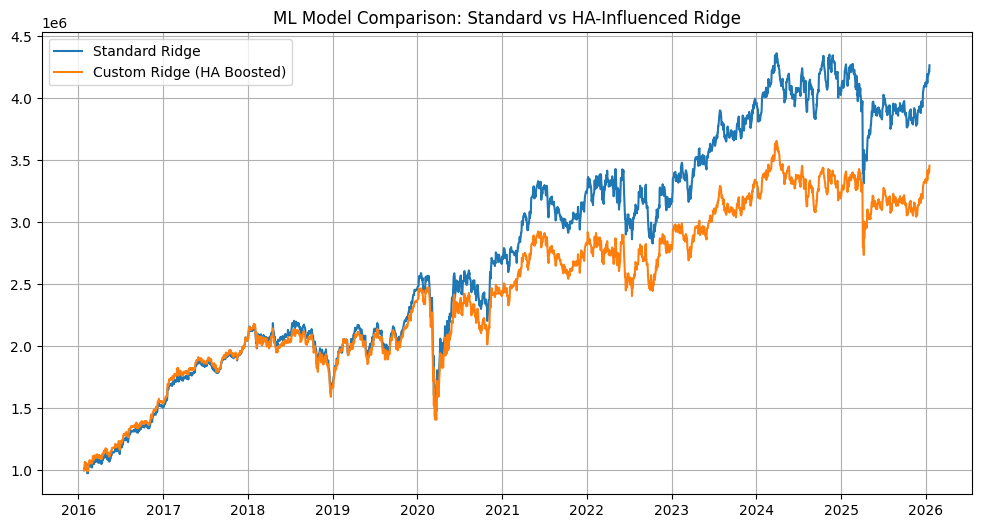

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(res_std.equity, label='Standard Ridge')
plt.plot(res_cust.equity, label='Custom Ridge (HA Boosted)')
plt.title('ML Model Comparison: Standard vs HA-Influenced Ridge')
plt.legend()
plt.grid(True)
plt.show()
